In [1]:
!pip freeze

astor==0.8.1
asttokens==2.4.0
autograd==1.6.2
autograd-gamma==0.5.0
auton-survival==1.0.1+tosa
backcall==0.2.0
Brotli==1.1.0
certifi==2023.7.22
charset-normalizer==3.2.0
cmake==3.27.5
comm==0.1.4
contourpy==1.1.1
cycler==0.11.0
debugpy==1.8.0
decorator==5.1.1
ecos==2.0.12
executing==1.2.0
feather-format==0.4.1
filelock==3.12.4
fonttools==4.42.1
formulaic==0.6.5
future==0.18.3
graphlib-backport==1.0.3
h5py==3.9.0
idna==3.4
importlib-metadata==6.8.0
importlib-resources==6.1.0
inflate64==0.3.1
interface-meta==1.3.0
ipykernel==6.25.2
ipython==8.12.2
jedi==0.19.0
Jinja2==3.1.2
joblib==1.3.2
jupyter-client==8.3.1
jupyter-core==5.3.2
kiwisolver==1.4.5
lifelines==0.27.8
lit==17.0.1
llvmlite==0.41.0
MarkupSafe==2.1.3
matplotlib==3.7.3
matplotlib-inline==0.1.6
mpmath==1.3.0
multivolumefile==0.2.3
nest-asyncio==1.5.8
networkx==3.1
numba==0.58.0
numexpr==2.8.6
numpy==1.24.4
nvidia-cublas-cu11==11.10.3.66
nvidia-cuda-cupti-cu11==11.7.101
nvidia-cuda-nvrtc-cu11==11.7.99
nvidia-cuda-runtime-cu11==11.

In [1]:
import survwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
X, y = survwrap.load_test_data()
X.shape, y.shape

((198, 84), (198,))

# DATA ANALYSIS - TEST

## Breast Cancer Dataset

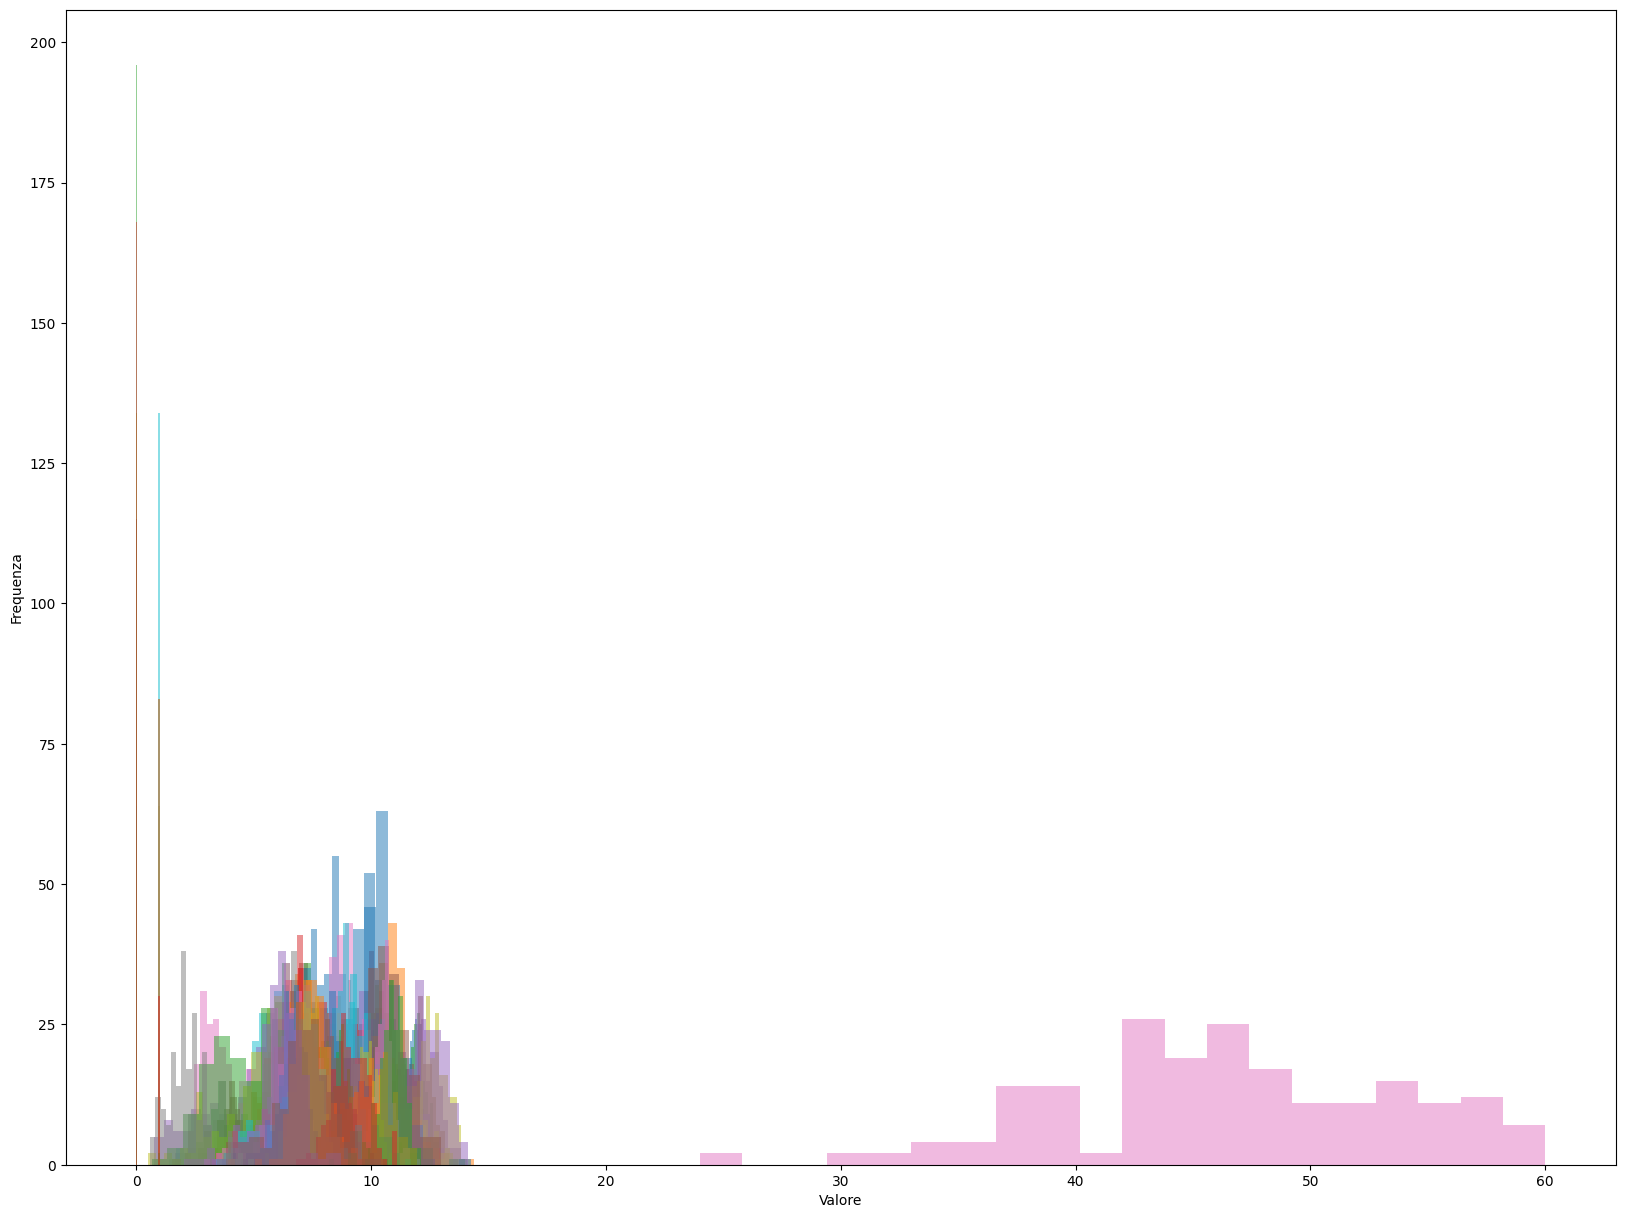

In [3]:
plt.figure(figsize=(20,15))
for i in range(X.shape[1]):
    plt.hist(X[:, i], bins=20, alpha=0.5, label=f'Feature {i+1}')

plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

Chiaramente si può osservare come la quasi totalità delle features sia distribuita sui primi valori. Solamente una feature è distribuita a valori maggiori di 20. Probabilmente risulta molto informativa. Inoltre si vedono chiaramente delle features a 0 e a 1 dunque features binarie, indicative probabilmente del Gender o di altre categorie simili.

Provo a vedere con la PCA la varianza che viene coperta dalle prime componenti principali così da usarla successivamente per diminuire la dimensione delle features.

In [4]:
n_components = 0.95
pca = PCA(n_components=n_components)

X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print("Varianza spiegata del {} dalle componenti principali:".format(n_components))
print(explained_variance)
print(f"\nComponenti che spiegano il {n_components} di varianza:\n{pca.n_components_}")

Varianza spiegata del 0.95 dalle componenti principali:
[0.41489442 0.08159963 0.05418136 0.04863746 0.03115645 0.02594613
 0.02407656 0.02033343 0.01689833 0.01566172 0.01564167 0.01419549
 0.01335213 0.01249853 0.01219721 0.01118671 0.01057144 0.00955595
 0.00906441 0.00865724 0.00817946 0.00766073 0.00738248 0.00677485
 0.00622116 0.00607401 0.00580039 0.00568294 0.00538958 0.00519731
 0.00489749 0.0044099  0.00433294 0.00418748 0.0037906  0.00360764
 0.00345027 0.0031941  0.00310659 0.0030872 ]

Componenti che spiegano il 0.95 di varianza:
40


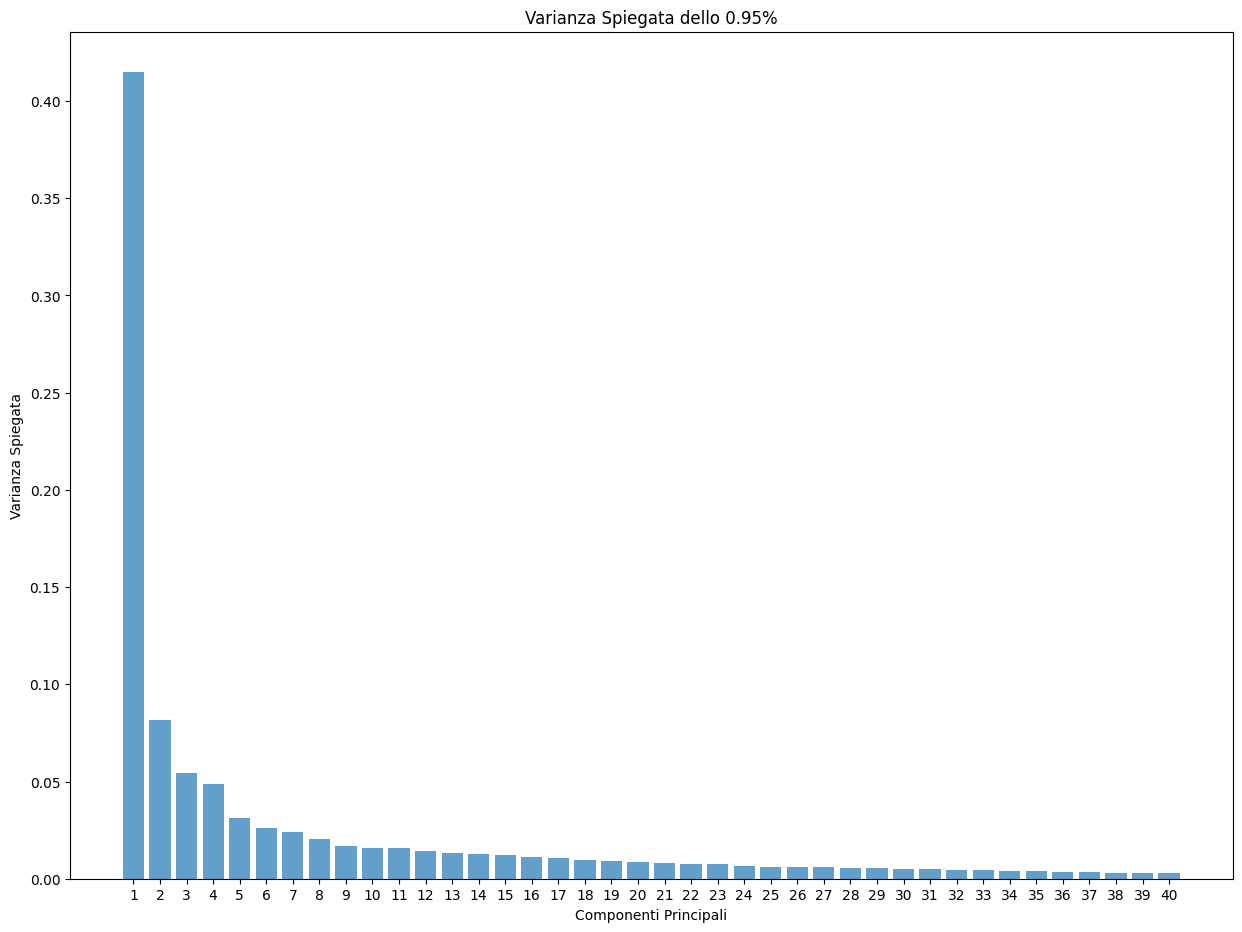

In [5]:
plt.figure(figsize=(15, 11))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, align='center', alpha=0.7)
plt.xlabel('Componenti Principali')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata dello {}%'.format(n_components))
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

### Test on Data

In [6]:
X_train, X_test, y_train, y_test = survwrap.survival_train_test_split(X, y,rng_seed=42)

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

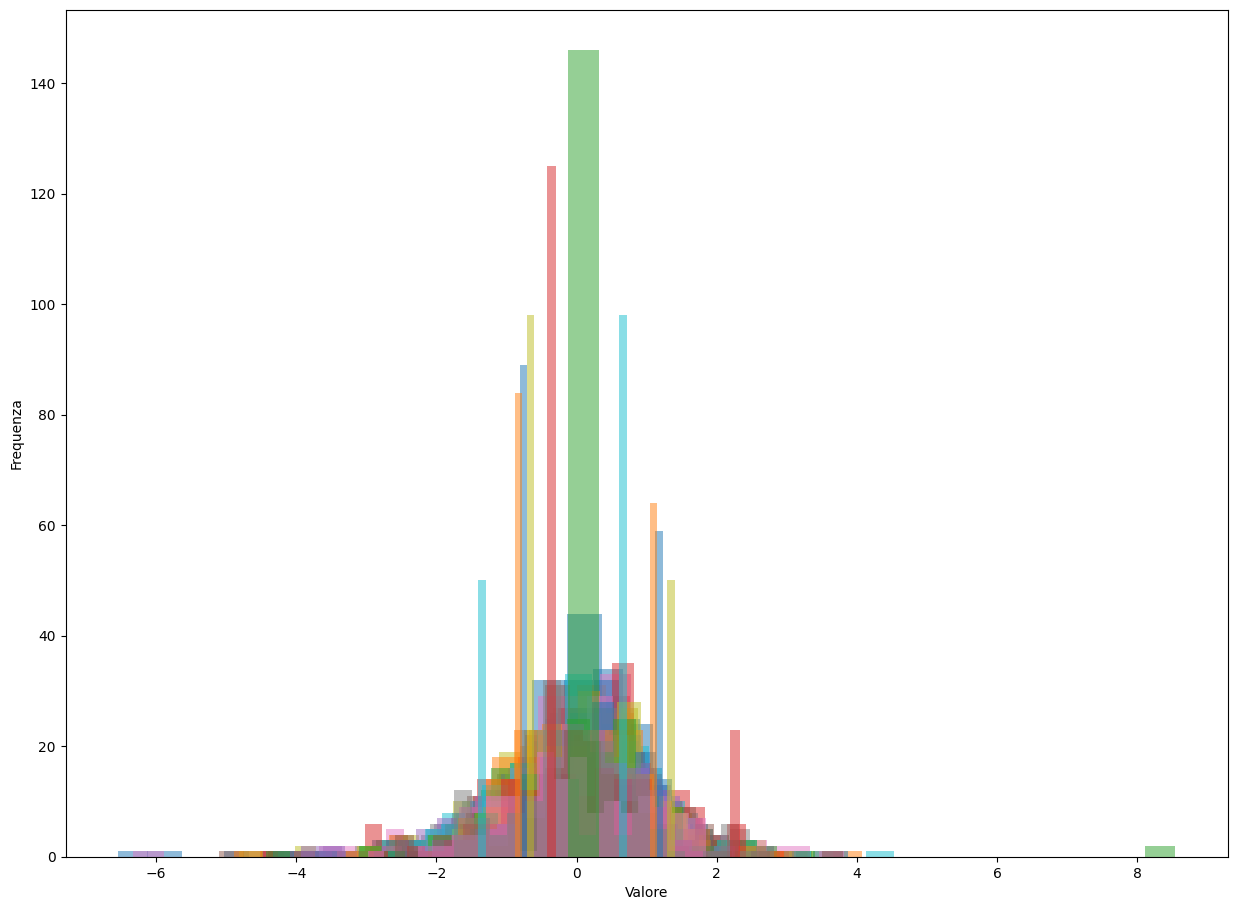

In [8]:
plt.figure(figsize=(15,11))
for i in range(X_train_std.shape[1]):
    plt.hist(X_train_std[:, i], bins=20, alpha=0.5, label=f'Feature {i+1}')

plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

In [9]:
coxnet = survwrap.CoxNet(rng_seed=42)
coxnet.fit(X_train_std, y_train)

CoxNet(rng_seed=42, alpha=None, l1_ratio=0.5, fit_baseline_model=False)

In [10]:
coxnet.score(X_train_std, y_train), coxnet.score(X_test_std, y_test)

(1.0, 0.5866141732283464)

In [11]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = survwrap.optimize(survwrap.CoxNet(rng_seed=42), X_train_std, y_train, mode='sklearn-random',)
opt_coxnet.score(X_train_std, y_train), opt_coxnet.score(X_test_std, y_test), opt_coxnet_params

Random search tries: 5


(0.9728936074090806, 0.6200787401574803, {'l1_ratio': 0.75, 'alpha': 0.005})

In [12]:
survwrap.get_top_models(opt_coxnet_search)

[(1,
  0.6256039483927444,
  0.08867522906769237,
  {'l1_ratio': 0.75, 'alpha': 0.005}),
 (2, 0.596176708780311, 0.09790464917415381, {'l1_ratio': 0.9, 'alpha': 0.02}),
 (3, 0.5536196783347344, 0.08006111809691774, {'l1_ratio': 0.5, 'alpha': 0.1}),
 (4,
  0.549629309161699,
  0.09427010622476166,
  {'l1_ratio': 0.99, 'alpha': 0.05}),
 (5,
  0.5401975515587496,
  0.0916242501268095,
  {'l1_ratio': 0.75, 'alpha': 0.08})]

In [13]:
survwrap.generate_topology_grid(max_width=4)

[[3], [4], [3, 3], [4, 4], [3, 3, 3], [4, 4, 4]]

### Test on PCA Data

In [15]:
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_train_pca, y_test_pca = y_train, y_test

In [16]:
scaler = StandardScaler()
scaler.fit(X_train_pca)
X_train_std_pca = scaler.transform(X_train_pca)
X_test_std_pca = scaler.transform(X_test_pca)

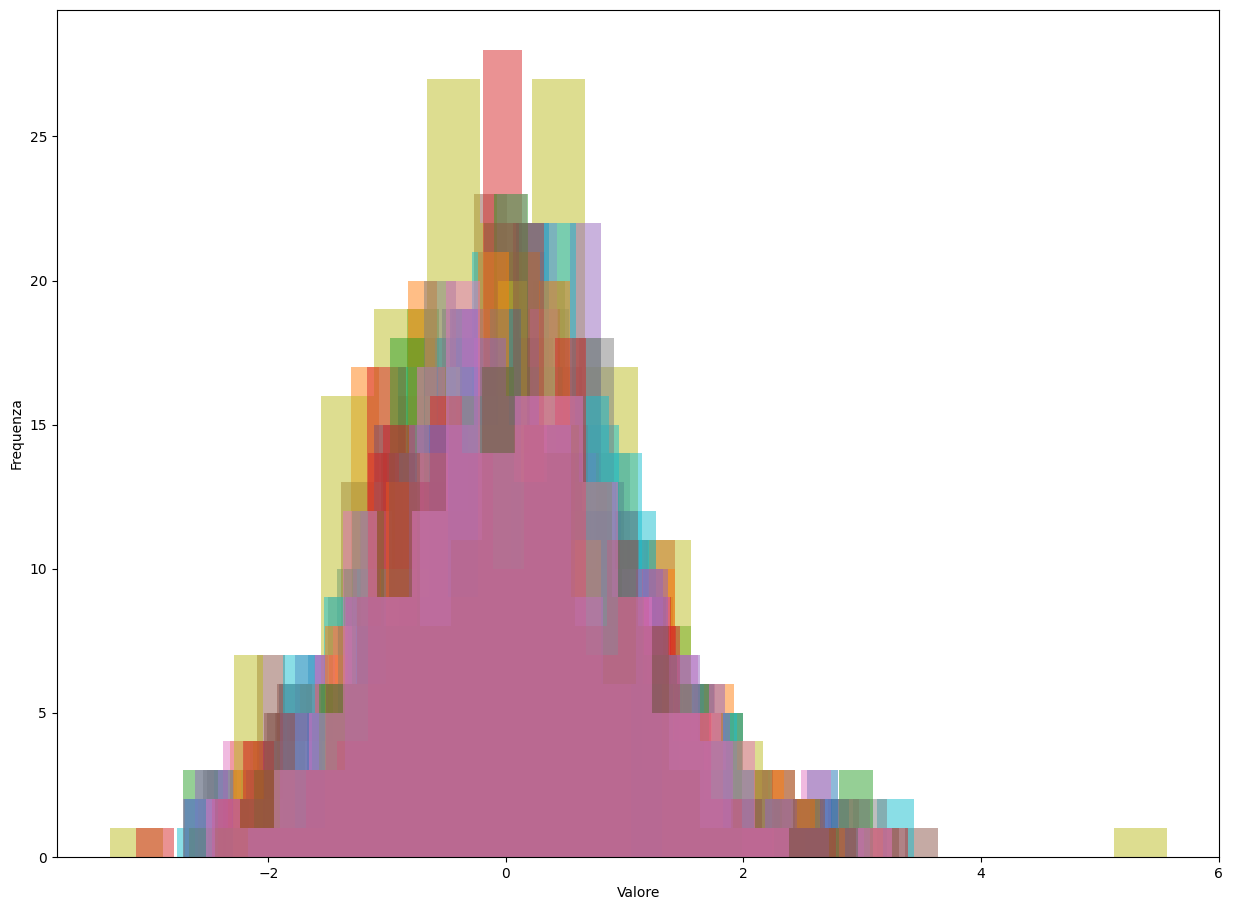

In [17]:
plt.figure(figsize=(15,11))
for i in range(X_train_std_pca.shape[1]):
    plt.hist(X_train_std_pca[:, i], bins=20, alpha=0.5, label=f'Feature {i+1}')

plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.show()

In [18]:
coxnet = survwrap.CoxNet(rng_seed=42)
coxnet.fit(X_train_std_pca, y_train_pca)

CoxNet(rng_seed=42, alpha=None, l1_ratio=0.5, fit_baseline_model=False)

In [19]:
coxnet.score(X_train_std_pca, y_train_pca), coxnet.score(X_test_std_pca, y_test_pca)

(0.8689857691438898, 0.6751968503937008)

In [20]:
opt_coxnet_pca, opt_coxnet_params_pca, opt_coxnet_search_pca = survwrap.optimize(survwrap.CoxNet(rng_seed=42), X_train_std_pca, y_train_pca, n_jobs=4)
opt_coxnet_pca.score(X_train_std_pca, y_train_pca), opt_coxnet_pca.score(X_test_std_pca, y_test_pca), opt_coxnet_params_pca

(0.8626609442060086, 0.7362204724409449, {'alpha': 0.02, 'l1_ratio': 0.9})

In [21]:
survwrap.get_top_models(opt_coxnet_search_pca)

[(1,
  0.6836352394311478,
  0.07152782448966742,
  {'alpha': 0.02, 'l1_ratio': 0.9}),
 (2,
  0.6813739741704701,
  0.06903101281806692,
  {'alpha': 0.02, 'l1_ratio': 0.99}),
 (3,
  0.6809574044959111,
  0.05604283145079997,
  {'alpha': 0.05, 'l1_ratio': 0.5}),
 (4,
  0.6806089634205316,
  0.05205123478727812,
  {'alpha': 0.08, 'l1_ratio': 0.25}),
 (5, 0.67973444460467, 0.059524633679556176, {'alpha': 0.03, 'l1_ratio': 0.9}),
 (6,
  0.679693756279841,
  0.06692978074848799,
  {'alpha': 0.05, 'l1_ratio': 0.25}),
 (7,
  0.6795017269532886,
  0.06485454722394203,
  {'alpha': 0.04, 'l1_ratio': 0.5}),
 (8,
  0.6793673470852309,
  0.05717735613755596,
  {'alpha': 0.07, 'l1_ratio': 0.25}),
 (9,
  0.6791571685122484,
  0.06964636315580161,
  {'alpha': 0.02, 'l1_ratio': 0.75}),
 (10,
  0.679011787832102,
  0.05914798147269738,
  {'alpha': 0.09, 'l1_ratio': 0.25})]

## FLChain Dataset

In [19]:
survwrap.list_available_datasets()

('flchain', 'gbsg2', 'metabric', 'support')

In [21]:
#mb_df = survwrap.get_data('flchain')
#mb_df.dataframe.info()

#TODO: Questo è un BUG, da risolvere

In [24]:
dataframe=pd.read_csv('../Datasets/flchain' + ".csv", index_col=0)
dataframe.head()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,time,event
0,97.0,0.0,1997,5.70,4.860,10,1.7,0.0,85.0,1.0
1,92.0,0.0,2000,0.87,0.683,1,0.9,0.0,1281.0,1.0
2,94.0,0.0,1997,4.36,3.850,10,1.4,0.0,69.0,1.0
3,92.0,0.0,1996,2.42,2.220,9,1.0,0.0,115.0,1.0
4,93.0,0.0,1996,1.32,1.690,6,1.1,0.0,1039.0,1.0


In [25]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6524 entries, 0 to 6523
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         6524 non-null   float64
 1   sex         6524 non-null   float64
 2   sample.yr   6524 non-null   int64  
 3   kappa       6524 non-null   float64
 4   lambda      6524 non-null   float64
 5   flc.grp     6524 non-null   int64  
 6   creatinine  6524 non-null   float64
 7   mgus        6524 non-null   float64
 8   time        6524 non-null   float64
 9   event       6524 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 560.7 KB
